# Y-Network

The Y-Network uses the same input twice, both on the left and right CNN branches. The network combines the results using a concatenate layer. The merge operation concatenate is similar to stacking two tensors of the same shape along the concatenation axis to form one tensor. 

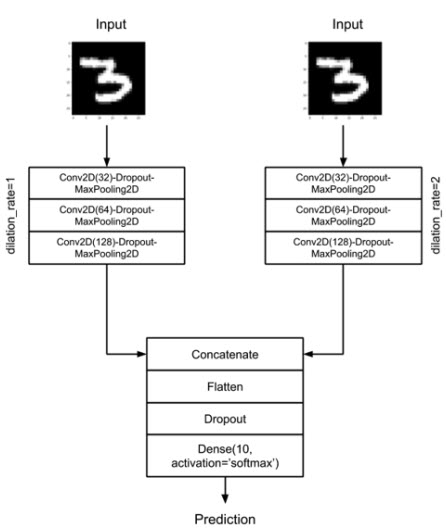

To improve the performance of the model, we can propose several changes. Firstly, the branches of the Y-Network are doubling the number of filters
to compensate for the halving of the feature maps size after MaxPooling2D(). 

For example, if the output of the first convolution is (28, 28, 32), after max pooling the new shape is (14, 14, 32). The next convolution will have a filter size of 64 and output dimensions of (14, 14, 64).

Second, although both branches have the same kernel size of 3, the right branch uses a dilation rate of 2. Figure 2.1.2 shows the effect of different dilation rates on a kernel with size 3. The idea is that by increasing the effective receptive field size of the kernel using dilation rate, the CNN will enable the right branch to learn different feature maps. Using a dilation rate greater than 1 is a computationally efficient approximate method to increase receptive field size. It is approximate since the kernel is not actually a full-blown kernel. It is efficient since we use the same number of operations as with a dilation rate equal to 1.

To appreciate the concept of the receptive field, notice that when the kernel computes each point of a feature map, its input is a patch in the previous layer feature map which is also dependent on its previous layer feature map. If we continue tracking this dependency down to the input image, the kernel depends on an image patch called the receptive field.

The two branches are created by the two for loops. Both branches expect the same input shape. The two for loops will create two 3-layer stacks of Conv2D-Dropout-MaxPooling2D. While we used the concatenate layer to combine the outputs of the left and right branches, we could also utilize the other merge functions of tf.keras, such as add, dot, and multiply. The choice of the merge function is not purely arbitrary but must be based on a sound model design decision.

Taking a step back, we can note that the Y-Network is expecting two inputs
for training and validation. The inputs are identical, so [x_train, x_train]
is supplied.

# Resnet

ResNet introduced the concept of residual learning, which enabled it to build very deep networks by addressing the vanishing gradient problem

One key advantage of deep networks is that they have a great ability to learn
different levels of representation from both inputs and feature maps.  In classification, segmentation, detection, and a number of other computer vision problems, learning different feature maps generally leads to a better performance.

you'll find that it's not easy to train deep networks because the gradient
may vanish (or explode) with depth in the shallow layers during backpropagation.

The network parameters are updated by backpropagation from the output layer to all previous layers. Since backpropagation is based on the chain rule, there is a tendency for the gradient to diminish as it reaches the shallow layers. This is due to the multiplication of small numbers, especially for small loss functions and parameter values

The number of multiplication operations will be proportional to the depth of the network. It's also worth noting that if the gradient degrades, the parameters will not be updated appropriately

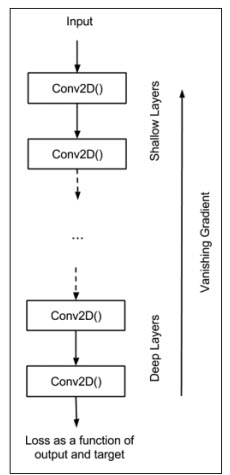

To alleviate the degradation of the gradient in deep networks, ResNet introduced the concept of a deep residual learning framework. Let's analyze a block: a small segment of our deep network.

The idea of ResNet is that in order to prevent the gradient from degrading,
we'll let the information flow through the shortcut connections to reach the
shallow layers.

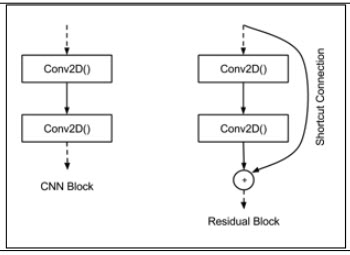

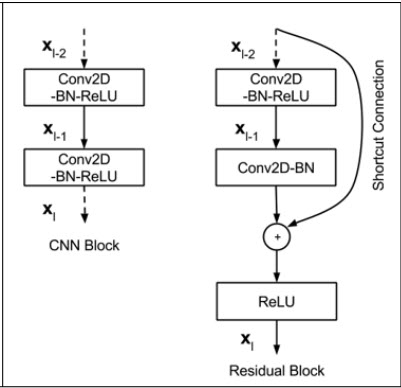

the residual mapping. The + sign is a tensor element-wise addition between the shortcut connection and the output of F(xl-1). The shortcut connection doesn't add extra parameters nor extra computational complexity.

The add operation can be implemented in tf.keras by the add() merge function.
However, both F(xl-1) and xl-2 should have the same dimensions.

If the dimensions are different, for example, when changing the feature maps size, we should perform a linear projection on xl-2 as to match the size of F(xl-1). In the original paper, the linear projection for the case, when the feature maps size is halved, is done by a Conv2D with a 1 × 1 kernel and strides=2.

stride > 1 is equivalent to skipping pixels during convolution. For example, if strides=2, we could skip every other pixel when we slide the kernel during the convolution process.

They imply that if the deeper layers can be trained to have fewer errors,
then there is no reason why the shallower layers should have higher errors.

ResNet uses kernel_initializer='he_normal' in order to aid the convergence when backpropagation is taking place. The last layer is made of AveragePooling2D-Flatten-Dense. It's worth noting at this point that ResNet
does not use dropout. It also appears that the add merge operation and the 1 x 1 convolution have a self-regularizing effect. 

use a learning rate (lr) scheduler, lr_schedule(), in order to schedule the decrease in lr at 80, 120, 160, and 180 epochs from the default 1e-3. The lr_schedule() function will be called after every epoch during training as part of the callbacks variable.

The other callback saves the checkpoint every time there is progress made in the validation accuracy. When training deep networks, it is a good practice to save the model or weight checkpoint. This is because it takes a substantial amount of time to train deep networks.

When you want to use your network, all you need to do is simply reload the
checkpoint, and the trained model is restored. This can be accomplished by calling tf.keras load_model(). The lr_reducer() function is included. In case the metric has plateaued before the scheduled reduction, this callback will reduce the learning rate by a certain factor supplied in the argument if the validation loss has not improved after patience = 5 epochs.

The tf.keras implementation uses data augmentation, ImageDataGenerator(), in order to provide additional training data as part of the regularization schemes. As the number of training data increases, generalization will
improve.

# ResNet v2

The improvements for ResNet v2 are mainly found in the arrangement of layers in the residual block 

The prominent changes in ResNet v2 are:
• The use of a stack of 1 x 1 – 3 x 3 – 1 × 1 BN-ReLU-Conv2D
• Batch normalization and ReLU activation come before two dimensional
convolution

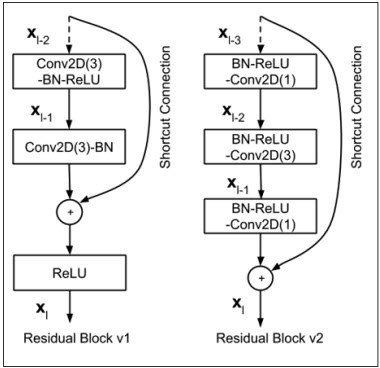

# DenseNet

DenseNet improved ResNet further by allowing every convolution to have direct
access to inputs, and lower layer feature maps. It's also managed to keep the
number of parameters low in deep networks by utilizing both the Bottleneck
and Transition layers.

DenseNet attacks the problem of vanishing gradient using a different approach.
Instead of using shortcut connections, all the previous feature maps will become the input of the next layer. The preceding figure shows an example of a Dense interconnection in one Dense block.

Notice that the input to layer l is the concatenation of all previous feature maps. If we let BN-ReLU-Conv2D be represented by the operation H(x), then the output of layer l is:

xl = H (x0,x1,x2,... ,xl-1)

Conv2D uses a kernel of size 3. The number of feature maps generated per layer is called the growth rate, k. Normally, k = 12, but k = 24 is also used

If the number of feature maps x0 is k0 , then the total number of feature maps at the end of the 4-layer Dense block will be 4 x k + k0.

DenseNet recommends that the Dense block is preceded by BN-ReLU-Conv2D, along
with a number of feature maps that is twice the growth rate, k0 = 2 x k. At the end of the Dense block, the total number of feature maps will be 4 x 12 + 2 x 12 = 72.

At the output layer, DenseNet suggests that we perform an average pooling before the Dense() with a softmax layer. If the data augmentation is not used, a dropout layer must follow the Dense block Conv2D.

As the network gets deeper, two new problems will occur. Firstly, since every layer contributes k feature maps, the number of inputs at layer l is (l – 1) x k + k0. The feature maps can grow rapidly within deep layers, slowing down the computation.

Secondly, similar to ResNet, as the network gets deeper the feature maps size
will be reduced to increase the receptive field size of the kernel. If DenseNet uses concatenation in the merge operation, it must reconcile the differences in size.

To prevent the number of feature maps from increasing to the point of being
computationally inefficient, DenseNet introduced the Bottleneck layer. The idea is that after every concatenation, a 1 x 1 convolution with a filter size equal to 4k is now applied. This dimensionality reduction technique prevents the number of feature maps to be processed by Conv2D(3) from rapidly increasing

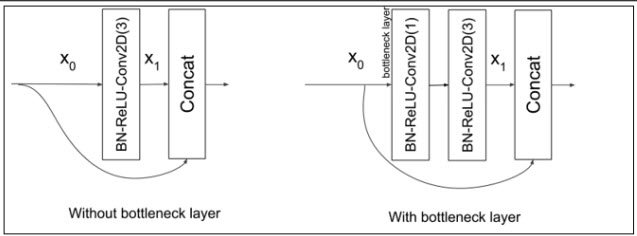

The Bottleneck layer then modifies the DenseNet layer as BN-ReLU-Conv2D(1)-
BN- ReLU-Conv2D(3), instead of just BN-ReLU-Conv2D(3). We've included the
kernel size as an argument of Conv2D for clarity. With the Bottleneck layer, every Conv2D(3) is processing just the 4k feature maps instead of (l – 1) x k + k0 for layer l. 

To solve the problem in feature maps size mismatch, DenseNet divides a deep
network into multiple Dense blocks that are joined together by transition layers. Within each Dense block, the feature map size (that is, width
and height) will remain constant.

The role of the transition layer is to transition from one feature map size to a smaller feature map size between two Dense blocks. The reduction in size is
usually half. This is accomplished by the average pooling layer. 

The input to the transition layer is the output of the last concatenation
layer in the previous Dense block

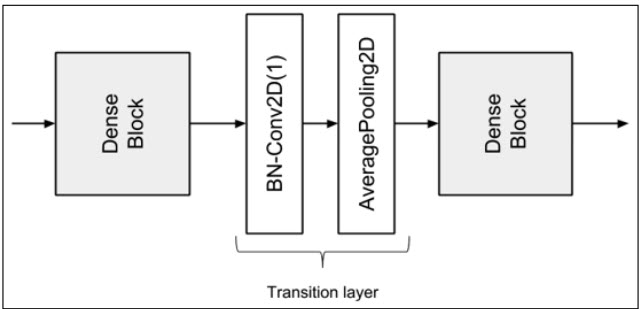

However, before the feature maps are passed to average pooling, their number
will be reduced by a certain compression factor, 0 < 𝜃𝜃 < 1, using Conv2D(1).
DenseNet uses 𝜃𝜃 = 0.5 in their experiment.

When compression and dimensionality reduction are put together, the transition layer is made of BNConv2D(1)-AveragePooling2D layers. In practice, batch normalization precedes the convolutional layer.

For the deeper layers, the growth_rate and depth variables must be changed